In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
import os
UP_DIR = '/Users/daniel421/Desktop/STAT_724/ISLR_data'

In [3]:
csv_file = os.path.join(UP_DIR,'Advertising.csv')
advertising = pd.read_csv(csv_file, usecols = [1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [4]:
csv_file = os.path.join(UP_DIR,'Credit.csv')
credit = pd.read_csv(csv_file, usecols = list(range(1,12)))
credit["Student2"] = credit.Student.map({"No":0, "Yes":1})
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0


In [5]:
csv_file = os.path.join(UP_DIR,'Auto.csv')
auto = pd.read_csv(csv_file, na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

/Users/daniel421/Desktop/STAT_724/ds_724/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


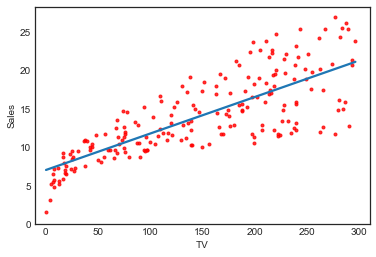

In [6]:
sns.regplot(advertising.TV, advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS

In [7]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X = scale(advertising.TV, with_mean = True, with_std=False).reshape(-1,1)
y = advertising.Sales

In [8]:
regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[0.04753664]


In [9]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

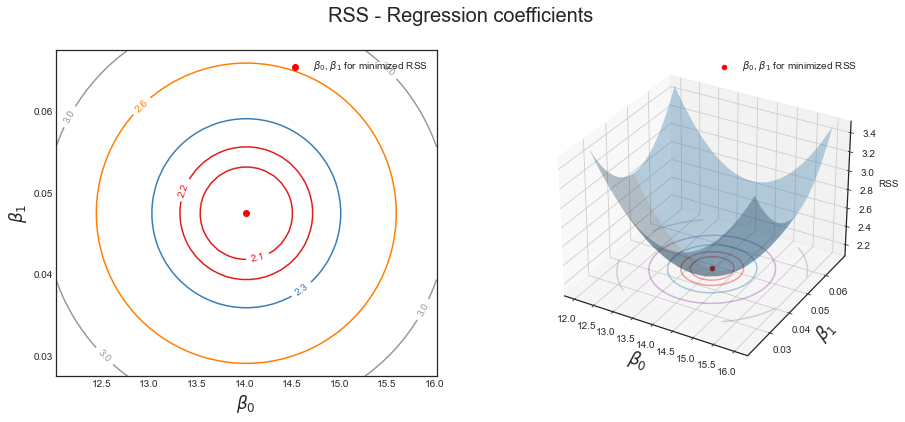

In [10]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.6, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels

In [11]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [12]:
est.tvalues

Intercept    15.360275
TV           17.667626
dtype: float64

In [13]:
# RSS with regression coefficients
((advertising.Sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()/1000

2.102530583131351

#### Table 3.1 & 3.2 - Scikit-learn

In [14]:
regr = skl_lm.LinearRegression()
 
X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.032593549127695
[0.04753664]


In [15]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.611875050850071

### 3.2 Multiple Linear Regression

#### Table 3.3 - Statsmodels

In [16]:
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


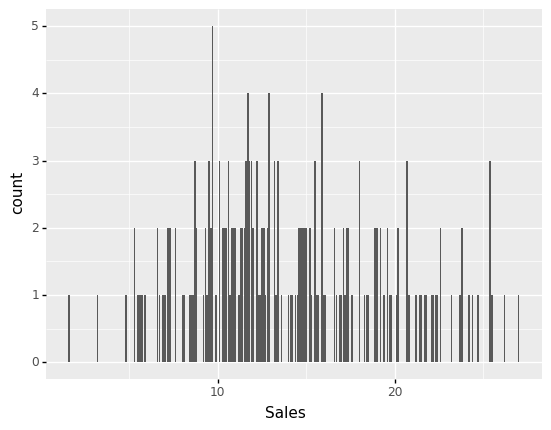

<ggplot: (8775078569924)>

In [17]:
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
%matplotlib inline

(ggplot(advertising) + aes(x = "Sales") + geom_bar(size = 20))

#### Table 3.4 & 3.6 - Statsmodels

In [18]:
est = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sat, 18 Sep 2021   Prob (F-statistic):           1.58e-96
Time:                        17:30:00   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Table 3.5 - Correlation Matrix

In [19]:
advertising.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


#### Figure 3.5 - Multiple Linear Regression

In [20]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV']].values
y = advertising.Sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


In [21]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

,Radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [22]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

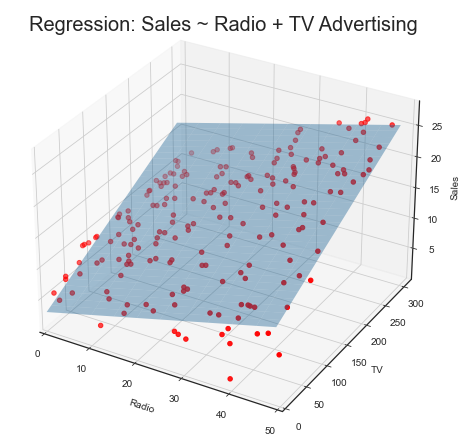

In [23]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)


ax = axes3d.Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');

### 3.3 Other Considerations in the Regression Model
#### Figure 3.6

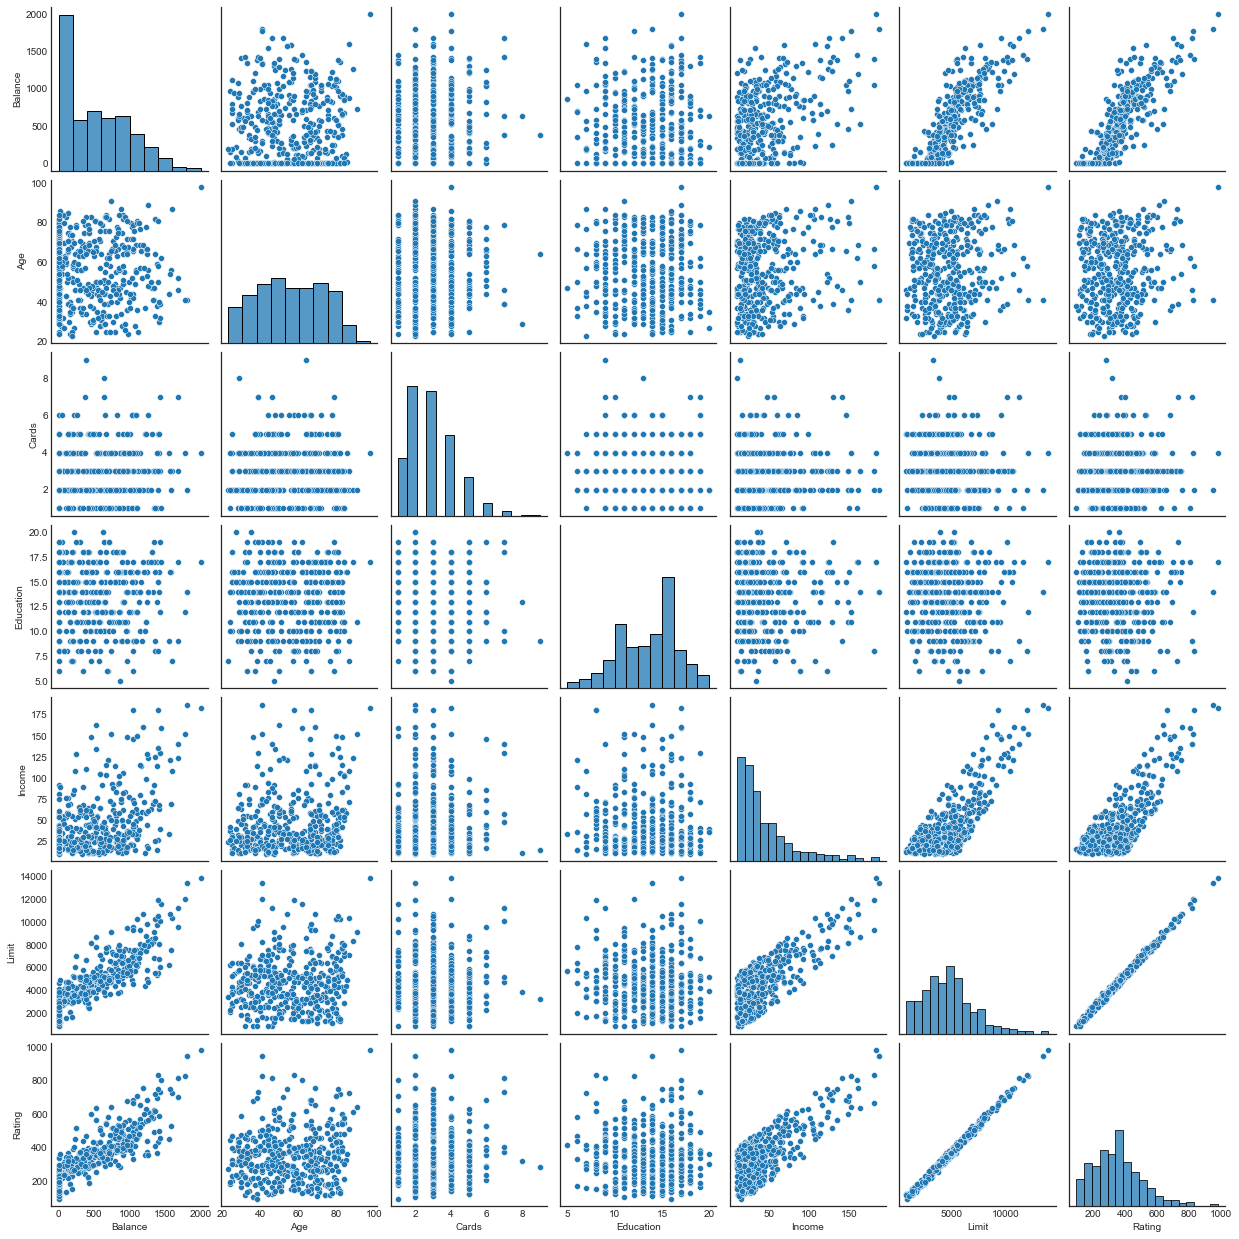

In [24]:
sns.pairplot(credit[["Balance", "Age", "Cards", "Education", "Income", "Limit", "Rating"]]);

#### Table 3.7 

In [25]:
est = smf.ols("Balance ~ Gender", credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


#### Table 3.8 

In [26]:
est = smf.ols("Balance~Ethnicity", credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


#### Table 3.9 - Interaction Variables

In [30]:
est = smf.ols("Sales ~ TV + Radio + TV*Radio", advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


### Figure 3.7 - Interaction between qualitative and quantitative variables

In [27]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


Object `np.linspace()` not found.


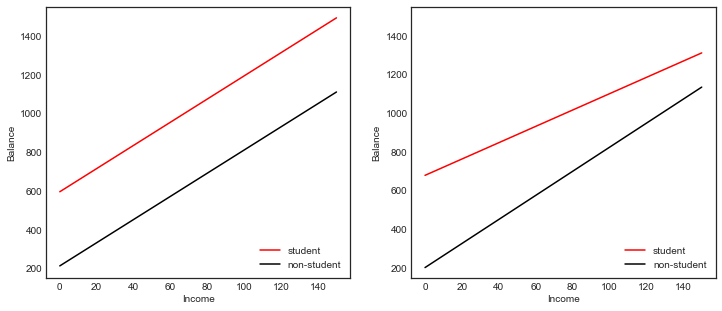

In [33]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=4)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

/Users/daniel421/Desktop/STAT_724/ds_724/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
/Users/daniel421/Desktop/STAT_724/ds_724/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
/Users/daniel421/Desktop/STAT_724/ds_724/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretat

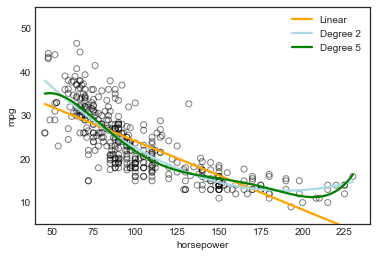

In [34]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Table 3.10

In [36]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,horsepower2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,16900.0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,27225.0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,22500.0


In [37]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


### Figure 3.9

In [41]:
regr = skl_lm.LinearRegression()
# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].values
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

/Users/daniel421/Desktop/STAT_724/ds_724/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
/Users/daniel421/Desktop/STAT_724/ds_724/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


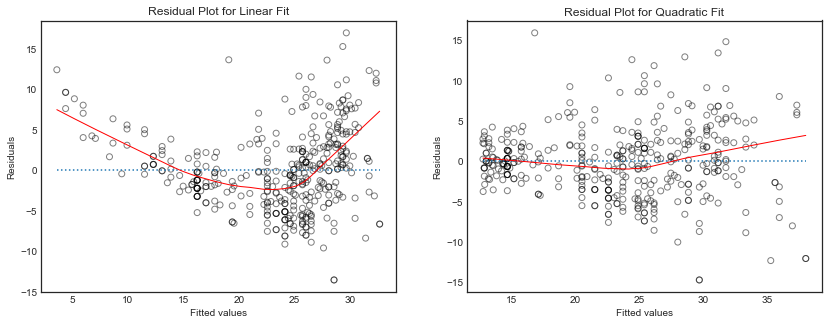

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))

# Left plot
sns.regplot(auto.pred1, auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(auto.pred2, auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

In [ ]:
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import train_test_split

# from yellowbrick.datasets import load_concrete
# from yellowbrick.regressor import ResidualsPlot

# auto_model_1 = regr.fit(X, y)
# auto_model_2 = regr.fit(X2,y)

# # Instantiate the linear model and visualizer
# model = Ridge()
# visualizer = ResidualsPlot(model)

# visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# visualizer.show()                 # Finalize and render the figure

### Figure 3.14

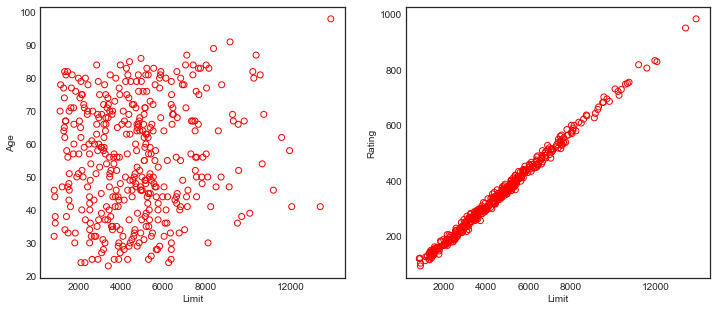

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [47]:
y = credit.Balance

# Regression for left plot
X = credit[['Age', 'Limit']].values
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['Rating', 'Limit']].values
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.0150000000001
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[2.20167217 0.02451438]
